<a href="https://colab.research.google.com/github/lakshayae162/Project-1/blob/main/Ensembler_Lung_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LUNG CANCER DETECTION USING ENSEMBLE MODEL - CNN and SVM**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import os
import numpy as np
from PIL import Image
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, ReLU, Add
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

print("Libraries Imported.")

Libraries Imported.


In [4]:
# Parameters
dataset_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
input_shape = (128, 128, 3)
num_classes = 3  # Normal, Benign, Malignant
class_names = ['Bengin', 'Malignant', 'Normal']
class_mapping = {class_name: index for index, class_name in enumerate(class_names)}

In [5]:
# Load and preprocess images
images = []
labels = []

for class_dir in os.listdir(dataset_path):
    class_dir_path = os.path.join(dataset_path, class_dir)
    if os.path.isdir(class_dir_path):
        print(f"Reading images from class directory: {class_dir}")
        for image_file in os.listdir(class_dir_path):
            image_path = os.path.join(class_dir_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img = img.resize(input_shape[:2])
                    img = np.array(img)
                    if img.shape == input_shape:
                        images.append(img)
                        labels.append(class_dir)  # Folder names are class labels
                    else:
                        print(f"Image {image_path} skipped due to shape mismatch.")
            except Exception as e:
                print(f"Error reading image {image_path}: {e}")

images = np.array(images, dtype=np.float32) / 255.0  # Normalizing image data to 0-1

Reading images from class directory: Normal cases
Reading images from class directory: Malignant cases
Reading images from class directory: Bengin cases


In [6]:
# Convert labels to categorical
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(integer_encoded, num_classes=num_classes)

In [7]:
# Shuffle dataset
shuffled_indices = np.arange(images.shape[0])
np.random.shuffle(shuffled_indices)
images = images[shuffled_indices]
labels = labels[shuffled_indices]

In [8]:
# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.25, random_state=42)

In [14]:
# Define the CNN model
inputs = Input(shape=input_shape)

# CNN layers
x = Conv2D(64, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Residual block
shortcut = x
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, shortcut])
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Additional layers with Dropout
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)
x = MaxPooling2D((2, 2))(x)

# Flatten and feature extraction
x = Flatten()(x)
features = Dense(256, activation='relu')(x)
x = Dropout(0.5)(features)

# **Add a softmax layer for classification**
classification_output = Dense(num_classes, activation='softmax')(x)

# Create CNN model with classification layer
cnn_model = Model(inputs, classification_output)
opt = Adam(learning_rate=0.0001)

# Compile CNN model
cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
print(cnn_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128, 128, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 128, 128, 64)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ re_lu_5[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 64, 64, 64)     │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)            │ (None, 64, 64, 64)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ re_lu_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 64, 64, 64)     │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64, 64)     │              0 │ batch_normalization_7… │
│                           │                        │                │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_7 (ReLU)            │ (None, 64, 64, 64)     │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 64)     │              0 │ re_lu_7[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 32, 32, 64)     │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_8 (ReLU)       

 Total params: 1,200,387 (4.58 MB)

 Trainable params: 1,199,747 (4.58 MB)

 Non-trainable params: 640 (2.50 KB)

None


In [16]:
# Callbacks
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=20, mode="max", restore_best_weights=True),
    ModelCheckpoint(filepath='model.h5.keras', monitor='val_accuracy', save_best_only=True)
]



In [17]:
# Train the CNN model
history = cnn_model.fit(train_images, train_labels, callbacks=callbacks, batch_size=16, epochs=80, validation_data=(test_images, test_labels))
cnn_model.save('model.h5')

Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.4723 - loss: 1.8528 - val_accuracy: 0.5273 - val_loss: 0.9939
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6280 - loss: 0.9297 - val_accuracy: 0.5273 - val_loss: 0.9709
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6675 - loss: 0.8073 - val_accuracy: 0.5273 - val_loss: 0.9795
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7180 - loss: 0.7512 - val_accuracy: 0.5273 - val_loss: 0.9750
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6953 - loss: 0.7019 - val_accuracy: 0.5273 - val_loss: 0.9469
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7385 - loss: 0.6142 - val_accuracy: 0.5273 - val_loss: 0.9098
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8078 - loss: 0.4871 - val_accuracy: 0.5273 - val_loss: 0.9367
Epoch 8/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7806 - loss: 0.5407 - val_accuracy: 0.5855 -

In [18]:
# Extract CNN features
train_features = cnn_model.predict(train_images)
test_features = cnn_model.predict(test_images)

# Flatten labels for SVM
train_labels_flat = np.argmax(train_labels, axis=1)
test_labels_flat = np.argmax(test_labels, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


In [21]:
# Train the SVM classifier
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features, train_labels_flat)

SVC(kernel='linear', probability=True)

In [22]:
# Save the trained SVM model
joblib.dump(svm_model, 'svm_lung_cancer_model.joblib')

['svm_lung_cancer_model.joblib']

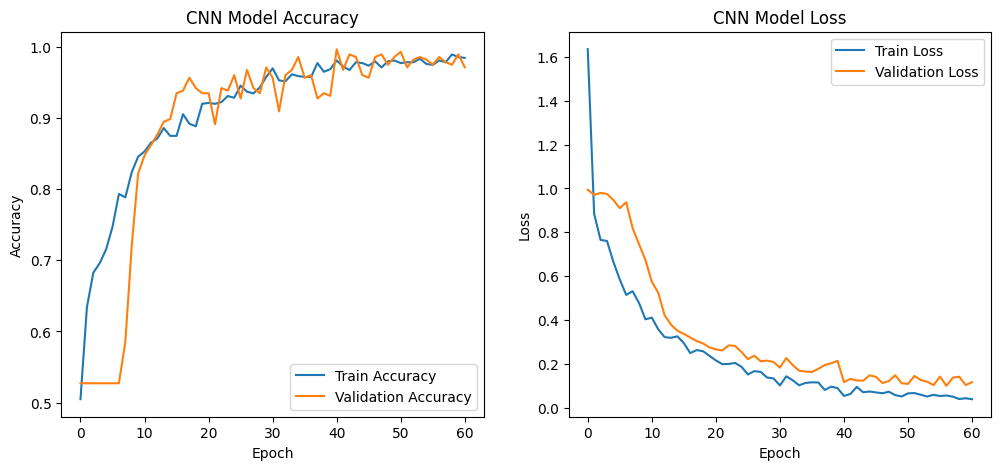

In [29]:
# Plot CNN accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
# Evaluate the SVM classifier
svm_predictions = svm_model.predict(test_features)
svm_accuracy = accuracy_score(test_labels_flat, svm_predictions)
print(f"Ensemble model: CNN-SVM Test Accuracy: {svm_accuracy}")

Ensemble model: CNN-SVM Test Accuracy: 0.9963636363636363


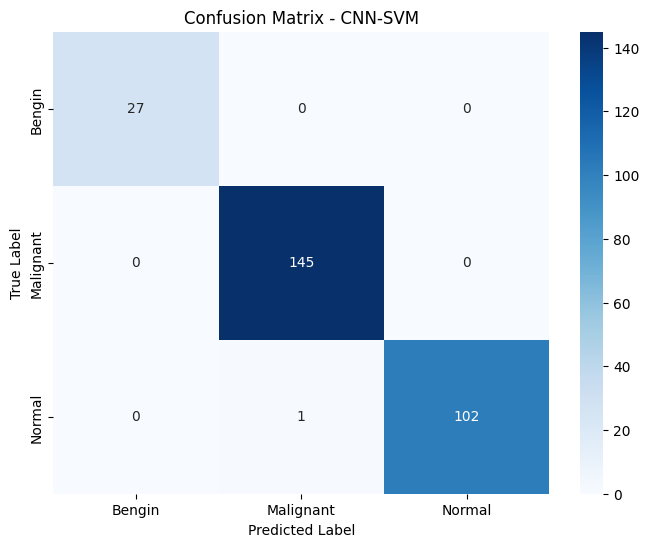

In [28]:
# Confusion matrix for SVM
cm = confusion_matrix(test_labels_flat, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - CNN-SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [30]:
# Predict labels using the trained SVM model
svm_predictions = svm_model.predict(test_features)
predicted_classes = svm_predictions  # Predicted labels (from SVM)
true_classes = test_labels_flat  # True labels

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)
for class_label, metrics in report.items():
    if class_label in class_names:  # Skip 'accuracy', 'macro avg', etc.
        print(f"{class_label}: Precision = {metrics['precision']:.2f}, Recall (Sensitivity) = {metrics['recall']:.2f}, F1-score = {metrics['f1-score']:.2f}")

# Specificity calculation for each class using the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
specificities = {}
for i, class_name in enumerate(class_names):
    true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    specificity = true_negatives / (true_negatives + false_positives)
    specificities[class_name] = specificity
    print(f"{class_name}: Specificity = {specificity:.2f}")


Classification Report:
Bengin: Precision = 1.00, Recall (Sensitivity) = 1.00, F1-score = 1.00
Malignant: Precision = 0.99, Recall (Sensitivity) = 1.00, F1-score = 1.00
Normal: Precision = 1.00, Recall (Sensitivity) = 0.99, F1-score = 1.00
Bengin: Specificity = 1.00
Malignant: Specificity = 0.99
Normal: Specificity = 1.00


AUC-ROC (Macro-Average): 1.00


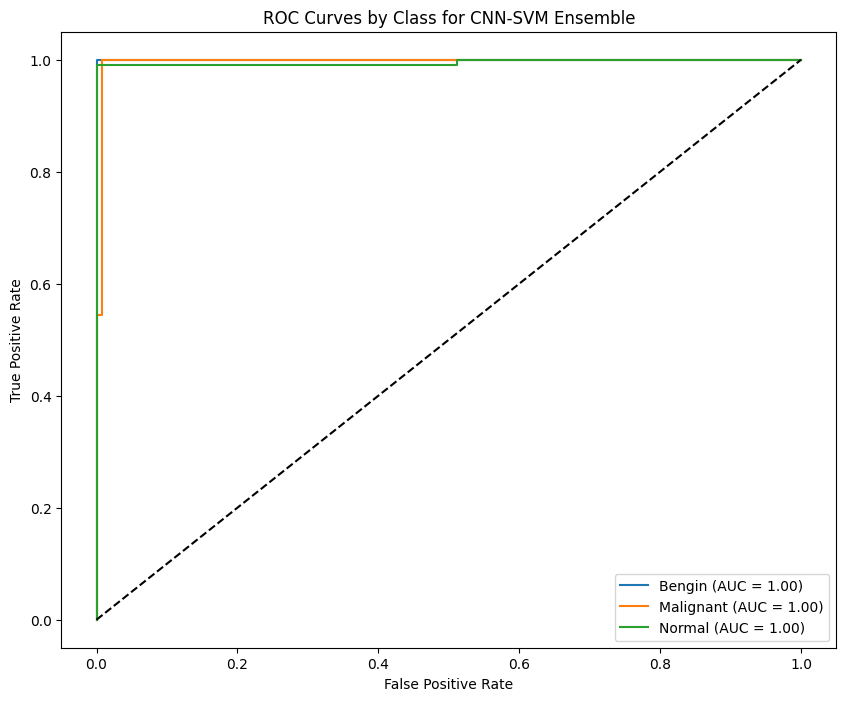

In [31]:
# Get predicted probabilities from the SVM model
svm_probabilities = svm_model.predict_proba(test_features)  # SVM probabilities

# AUC-ROC for each class (macro-average)
auc_roc = roc_auc_score(test_labels, svm_probabilities, average="macro", multi_class="ovr")
print(f"AUC-ROC (Macro-Average): {auc_roc:.2f}")

# Plot AUC-ROC curves for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(test_labels[:, i], svm_probabilities[:, i])  # Use probabilities for ROC
    auc_score = roc_auc_score(test_labels[:, i], svm_probabilities[:, i])  # AUC for each class
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

# Diagonal line for random chance
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class for CNN-SVM Ensemble')
plt.legend(loc='lower right')
plt.show()

In [32]:
def predict_image(img_path, cnn_model, svm_model, input_shape=(128, 128, 3)):
    try:
        # Load and preprocess the image
        with Image.open(img_path) as img:
            img = img.resize(input_shape[:2])  # Resize image to model's expected input shape
            img_array = np.array(img) / 255.0  # Normalize to [0, 1]
            if img_array.shape != input_shape:
                raise ValueError(f"Image shape mismatch: expected {input_shape}, got {img_array.shape}")
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Extract features using CNN model
            cnn_features = cnn_model.predict(img_array)  # Extract features from CNN model

            # Predict the class using SVM model
            predicted_class_index = svm_model.predict(cnn_features)[0]  # SVM class prediction
            predicted_label = class_names[predicted_class_index]

            # Display the image with prediction
            plt.imshow(img)  # Display the original image
            plt.title(f"Predicted: {predicted_label}")  # Add prediction title
            plt.axis('off')  # Hide axes
            plt.show()  # Show the image with title

            return predicted_label
    except Exception as e:
        print(f"Error loading or processing the image: {e}")
        return None


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


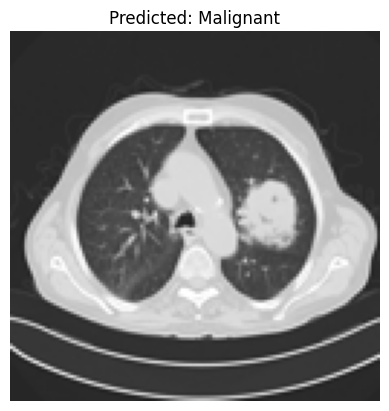

The image belongs to class: Malignant


In [33]:
# Usage
img_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (10).jpg'  # Image path
predicted_label = predict_image(img_path, cnn_model, svm_model)
print(f"The image belongs to class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


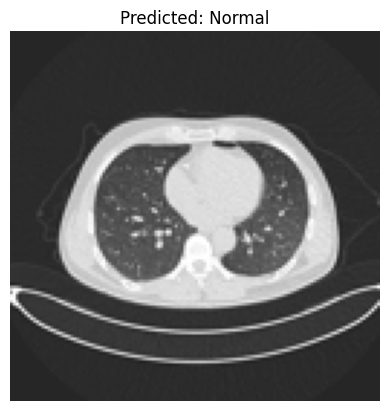

The image belongs to class: Normal


In [34]:
# Usage
img_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (10).jpg'  # Image path
predicted_label = predict_image(img_path, cnn_model, svm_model)
print(f"The image belongs to class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


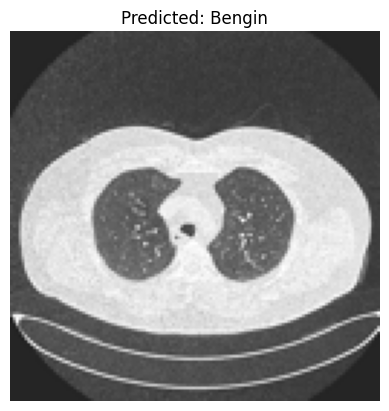

The image belongs to class: Bengin


In [35]:
# Usage
img_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (104).jpg'  # Image path
predicted_label = predict_image(img_path, cnn_model, svm_model)
print(f"The image belongs to class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


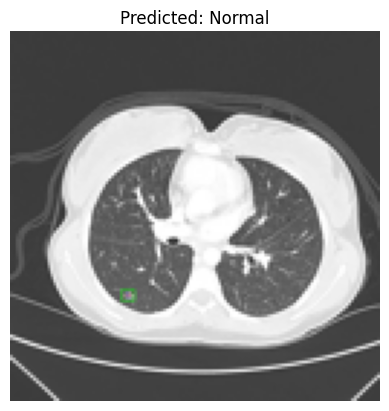

The image belongs to class: Normal


In [36]:
# Test- Usage
img_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Test cases/000027_02_01_105.png'  # Image path
predicted_label = predict_image(img_path, cnn_model, svm_model)
print(f"The image belongs to class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


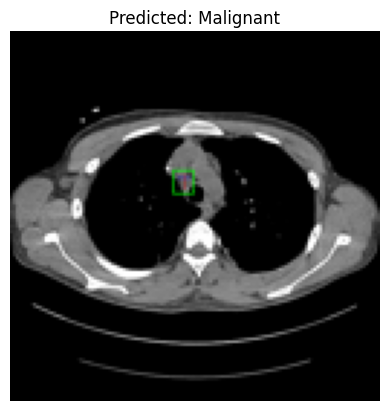

The image belongs to class: Malignant


In [37]:
# Test- Usage
img_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Test cases/000103_13_02_092.png'  # Image path
predicted_label = predict_image(img_path, cnn_model, svm_model)
print(f"The image belongs to class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


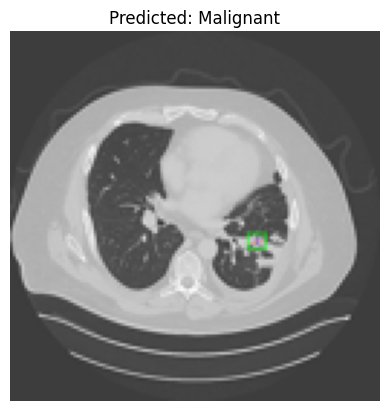

The image belongs to class: Malignant


In [38]:
# Test- Usage
img_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Test cases/000143_04_02_153.png'  # Image path
predicted_label = predict_image(img_path, cnn_model, svm_model)
print(f"The image belongs to class: {predicted_label}")